In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from shapely.geometry import LineString
from shapely.ops import split, transform
from cartopy.mpl.patch import geos_to_path
from matplotlib.patches import PathPatch
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection

from functions.functions import get_region_coords, create_map, region_contours
from functions.latex import set_size


datadir = "../data/"
figdir = "../figures/"

In [7]:
ds = xr.open_dataset(datadir + "mean_dynamic_topography_dtu_ease.nc")
ds

<xarray.Dataset> Size: 1MB
Dimensions:  (y: 264, x: 264)
Coordinates:
    lat      (y, x) float32 279kB ...
    lon      (y, x) float32 279kB ...
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    mdt      (y, x) float64 558kB ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        DTU15MDT_2min.mdt.nc
    source:       Danish National Space Center
    node_offset:  1

In [8]:
mask = xr.open_dataarray(datadir + "arctic_ocean/contourmask_eff_1000.nc").squeeze().drop_vars("depth")
ds_masked = ds.where(mask)

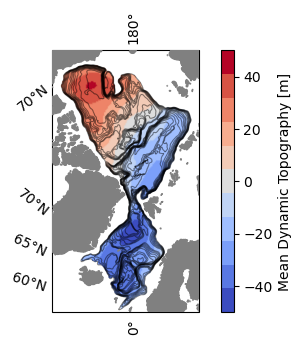

In [9]:
fig, ax = plt.subplots(1, 1,
                           figsize=set_size(width="AGU"),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
cmap = plt.get_cmap("coolwarm", 11)
cmap.set_bad('none')


c = ax.pcolormesh(ds_masked.lon, ds_masked.lat, ds_masked.mdt*100,
                  transform=ccrs.PlateCarree(),
                  vmin=-50,
                  vmax=50,
                  cmap=cmap,
                  shading='gouraud'
                 )

# Adjust longitudes to 0–360
ds_copy = ds_masked.copy(deep=True)
mask_copy = ds_copy.lon < 0
ds_copy = ds_masked.assign_coords(lon=xr.where(mask_copy, ds_masked.lon + 360, ds_masked.lon))

for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        # Load contour
        contour = xr.open_dataset(datadir + region_name + f"/contour_eff_{contour_depth}.nc")

        # Interpolate both datasets
        ds_interp = ds_masked.interp(x=contour.x, y=contour.y, method="linear")
        ds_copy_interp = ds_copy.interp(x=contour.x, y=contour.y, method="linear")

        # Assign corrected longitudes
        ds_interp = ds_interp.assign_coords(
            lon=xr.where(np.abs(ds_interp.lon) < 1, ds_interp.lon, ds_copy_interp.lon)
        )

        # Get lat/lon values
        lat = ds_interp.lat.values
        lon = ds_interp.lon.values

        lat = np.append(lat, lat[0])
        lon = np.append(lon, lon[0])

        # Fix wrap-around discontinuity across 180°
        dlon = np.diff(lon)
        jumps = np.where(np.abs(dlon) > 180)[0]
        lon_fixed = lon.copy()
        
        for j in jumps:
            if lon[j+1] - lon[j] > 180:
                lon_fixed[j+1:] -= 360
            elif lon[j+1] - lon[j] < -180:
                lon_fixed[j+1:] += 360
        

        # Build line segments [(x0,y0)->(x1,y1), ...]
        segments = np.array([
            [[lon_fixed[i], lat[i]], [lon_fixed[i+1], lat[i+1]]]
            for i in range(len(lon_fixed) - 1)
        ])

        # Create and add LineCollection
        lc = LineCollection(
            segments,
            colors="black",
            linewidths=0.75,
            alpha=0.5,
            transform=ccrs.PlateCarree()
        )
        cl = ax.add_collection(lc)
        cl.set_rasterized(True)

ax.add_feature(cfeature.LAND, color="grey", zorder=100)
gl0 = ax.gridlines(draw_labels=True, zorder=1, y_inline=False)
gl0.xlines = False
gl0.ylines = False
gl0.right_labels = False
fig.colorbar(c, label="Mean Dynamic Topography [m]")
fig.savefig(figdir + "mdt_with_contours.pdf", bbox_inches="tight", dpi=600)